In [2]:
%reset
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import datetime
import os
import sys
import utils
import time

from skimage.io import imread
from skimage.transform import resize

from tensorflow.python.framework.ops import reset_default_graph
from tensorflow.contrib.layers import fully_connected, conv2d, flatten, batch_norm, max_pool2d, dropout
from tensorflow.python.ops.nn import relu, elu, relu6, sigmoid, tanh, softmax
from tensorflow.python.ops.nn import dynamic_rnn

import tensorflow.contrib.slim as slim

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[int(row), int(col)] = 1
    return out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

#### Get paths

In [4]:
dataFolder = '/home/kristoffer/Documents/data'
tfrecords_training_filename = 'ballNoBallGrey_training.tfrecords'#'ballNoBall_training.tfrecords'
tfrecords_training_filepath = os.path.join(dataFolder,tfrecords_training_filename)
tfrecords_validation_filename = 'ballNoBallGrey_validation.tfrecords'
tfrecords_validation_filepath = os.path.join(dataFolder,tfrecords_validation_filename)

print("Training data path: %s"% tfrecords_training_filepath)
print("Validation data path: %s"% tfrecords_validation_filepath)

# current path
script_path = os.path.dirname(os.path.abspath("__file__"))
print(script_path)

Training data path: /home/kristoffer/Documents/data/ballNoBallGrey_training.tfrecords
Validation data path: /home/kristoffer/Documents/data/ballNoBallGrey_validation.tfrecords
/home/kristoffer/Dropbox/DTU/Deep_learning_-_02456/wearetracking/simpleNet


# Defining the data loader

In [29]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 1
IMAGE_SHAPE = [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS]
ANNOTATION_WIDTH = 1
NUM_OF_CLASSES = 2

TRAINING_BATCH_SIZE = 32
VALIDATION_BATCH_SIZE = 32
VALIDATION_SIZE = 32
VALIDATION_SIZE = np.floor(VALIDATION_SIZE/VALIDATION_BATCH_SIZE)*VALIDATION_BATCH_SIZE
VALIDATION_BATCH_NUM = int(VALIDATION_SIZE/VALIDATION_BATCH_SIZE)

CAPACITY = 5000
NUM_THREADS = 8
MIN_AFTER_DEQUEUE = 1000

NUM_EPOCHS = 1000


def read_and_decode(filename_queue, batch_size):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'img_height': tf.FixedLenFeature([], tf.int64),
        'img_width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'annotation_width': tf.FixedLenFeature([], tf.int64),  
        'annotation_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['annotation_raw'], tf.uint8)
    
    img_height = tf.cast(features['img_height'], tf.int32)
    img_width = tf.cast(features['img_width'], tf.int32)
    annotation_width = tf.cast(features['annotation_width'], tf.int32)
    
    image_shape = tf.stack([img_height, img_width, IMAGE_CHANNELS])
    annotation_shape = tf.stack([1, annotation_width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)

    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=1,
                                           target_width=ANNOTATION_WIDTH)
    
    
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=batch_size,
                                                 capacity=CAPACITY,
                                                 num_threads=NUM_THREADS,
                                                 min_after_dequeue=MIN_AFTER_DEQUEUE)
    
    return images, annotations

# Display samples from dataset

In [6]:
#tf.reset_default_graph()
# Array to contain loaded images
training_image_appended = []
validation_image_appended = []

print(tfrecords_training_filepath)
print(tfrecords_validation_filepath)

filename_training_queue = tf.train.string_input_producer(
    [tfrecords_training_filepath], num_epochs=NUM_EPOCHS)
filename_validation_queue = tf.train.string_input_producer(
    [tfrecords_validation_filepath], num_epochs=NUM_EPOCHS)

# Even when reading in multiple threads, share the filename
# queue.
training_image, training_annotation = read_and_decode(filename_training_queue, TRAINING_BATCH_SIZE)
validation_image, validation_annotation = read_and_decode(filename_validation_queue, VALIDATION_BATCH_SIZE)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    # Controlling of threads
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
     
    NUM_OF_BATCHES = 1
    
    # Load batches of data
    for i in range(NUM_OF_BATCHES):
    
        training_img, training_anno = sess.run([training_image, training_annotation])
        validation_img, validation_anno = sess.run([validation_image, validation_annotation])
        
        # Append loaded images
        for j in range(training_img.shape[0]):
            training_image_appended.append(training_img[j,:,:,:])
        # Append loaded images
        for j in range(validation_img.shape[0]):    
            validation_image_appended.append(validation_img[j,:,:,:])
        training_anno = np.squeeze(training_anno, axis=(1,2,3))
        training_anno= onehot(training_anno,NUM_OF_CLASSES)
        validation_anno = np.squeeze(validation_anno, axis=(1,2,3))
        validation_anno= onehot(validation_anno,NUM_OF_CLASSES)
    
    # Stop threads
    coord.request_stop()
    coord.join(threads)

/home/kristoffer/Documents/data/ballNoBallGrey_training.tfrecords
/home/kristoffer/Documents/data/ballNoBallGrey_validation.tfrecords


## Data investigation

Training images:


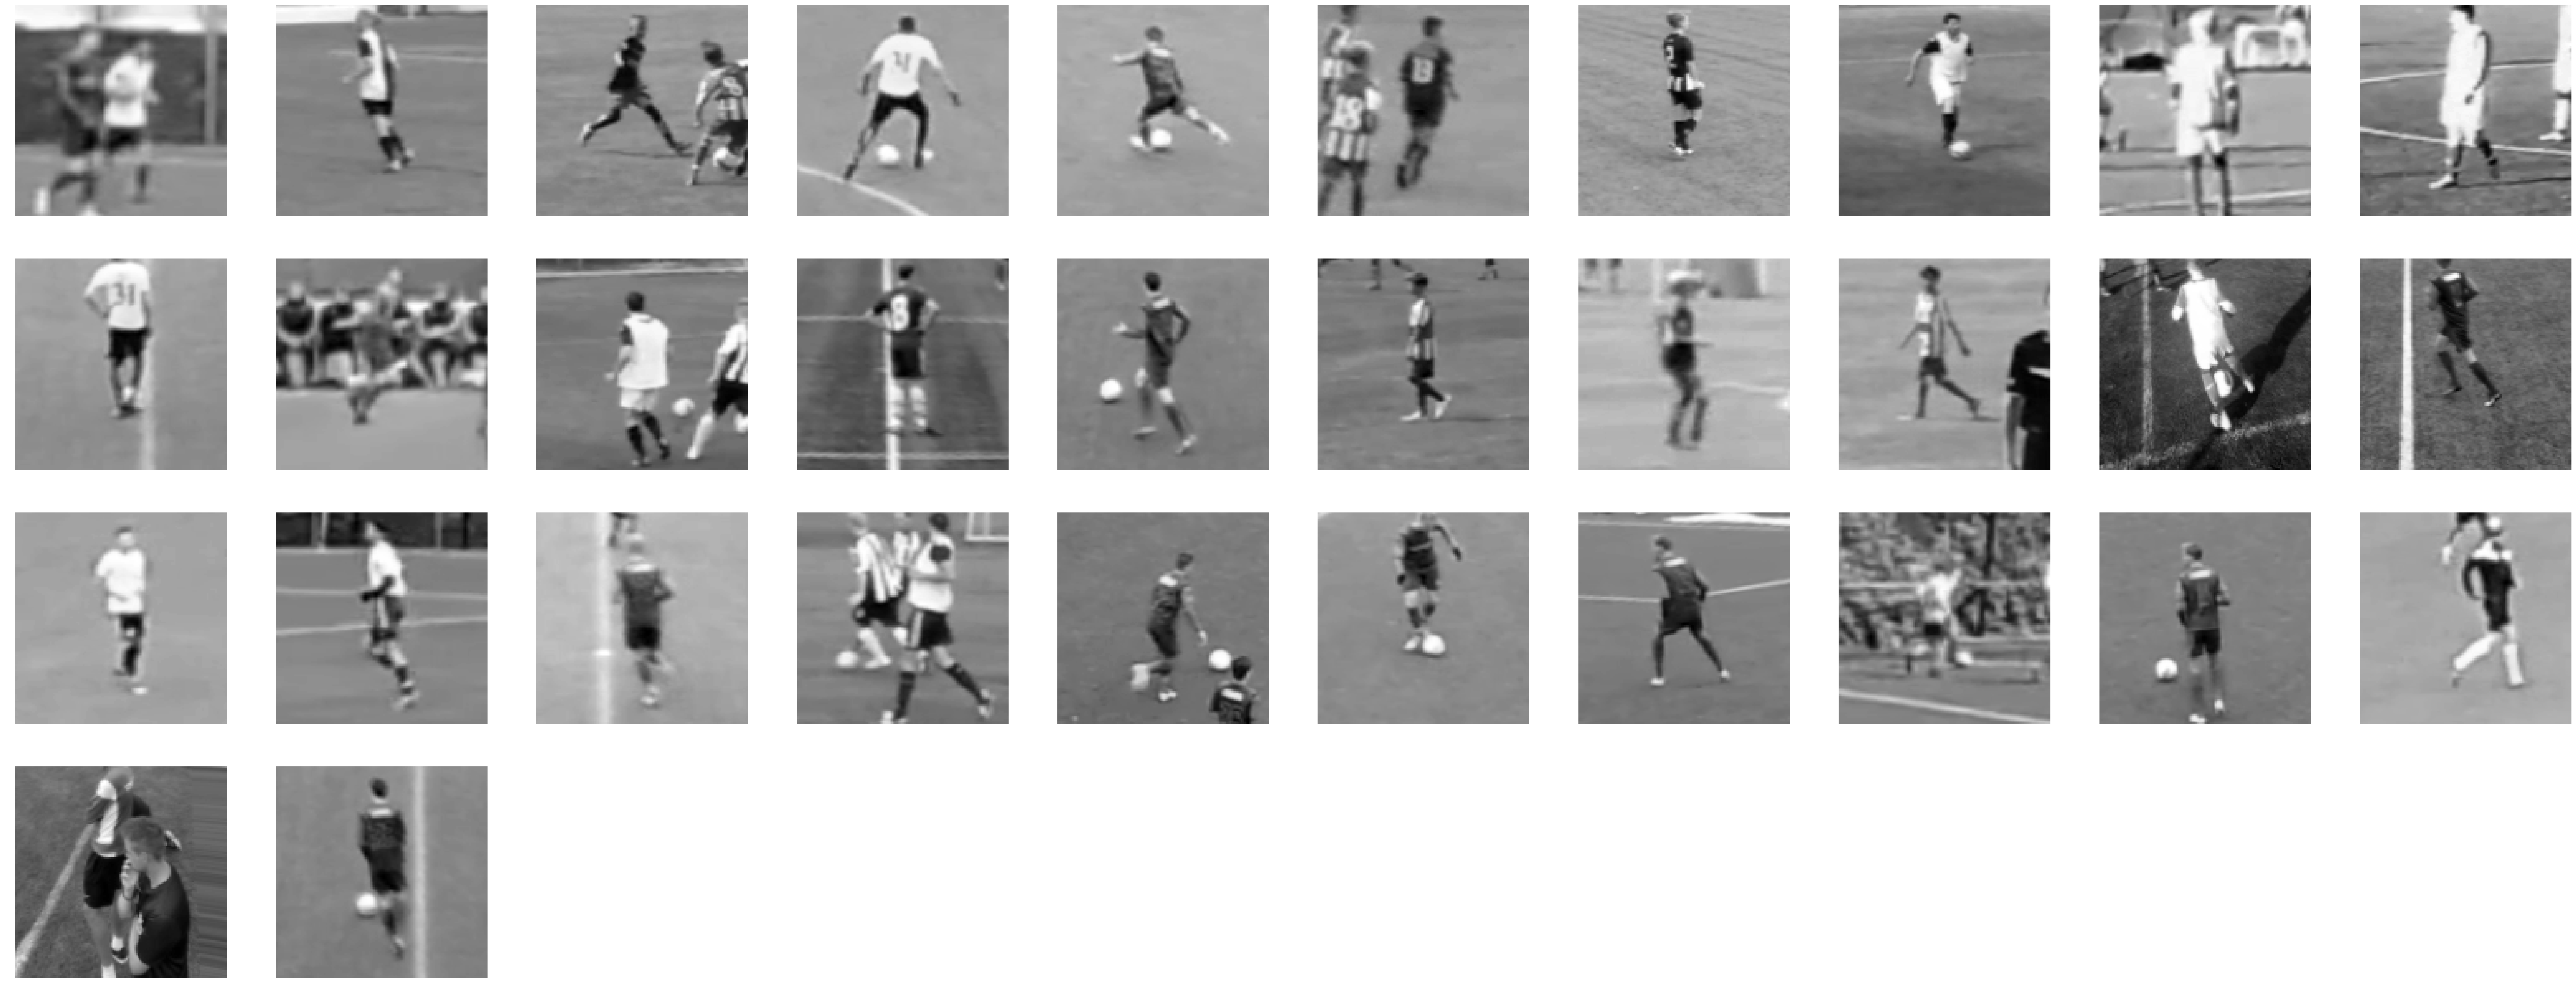

0.0		0.0		1.0		1.0		1.0		0.0		0.0		1.0		0.0		0.0		1.0		0.0		1.0		0.0		1.0		0.0		0.0		0.0		1.0		0.0		0.0		0.0		0.0		1.0		1.0		1.0		0.0		1.0		1.0		0.0		0.0		1.0		

Validation images:


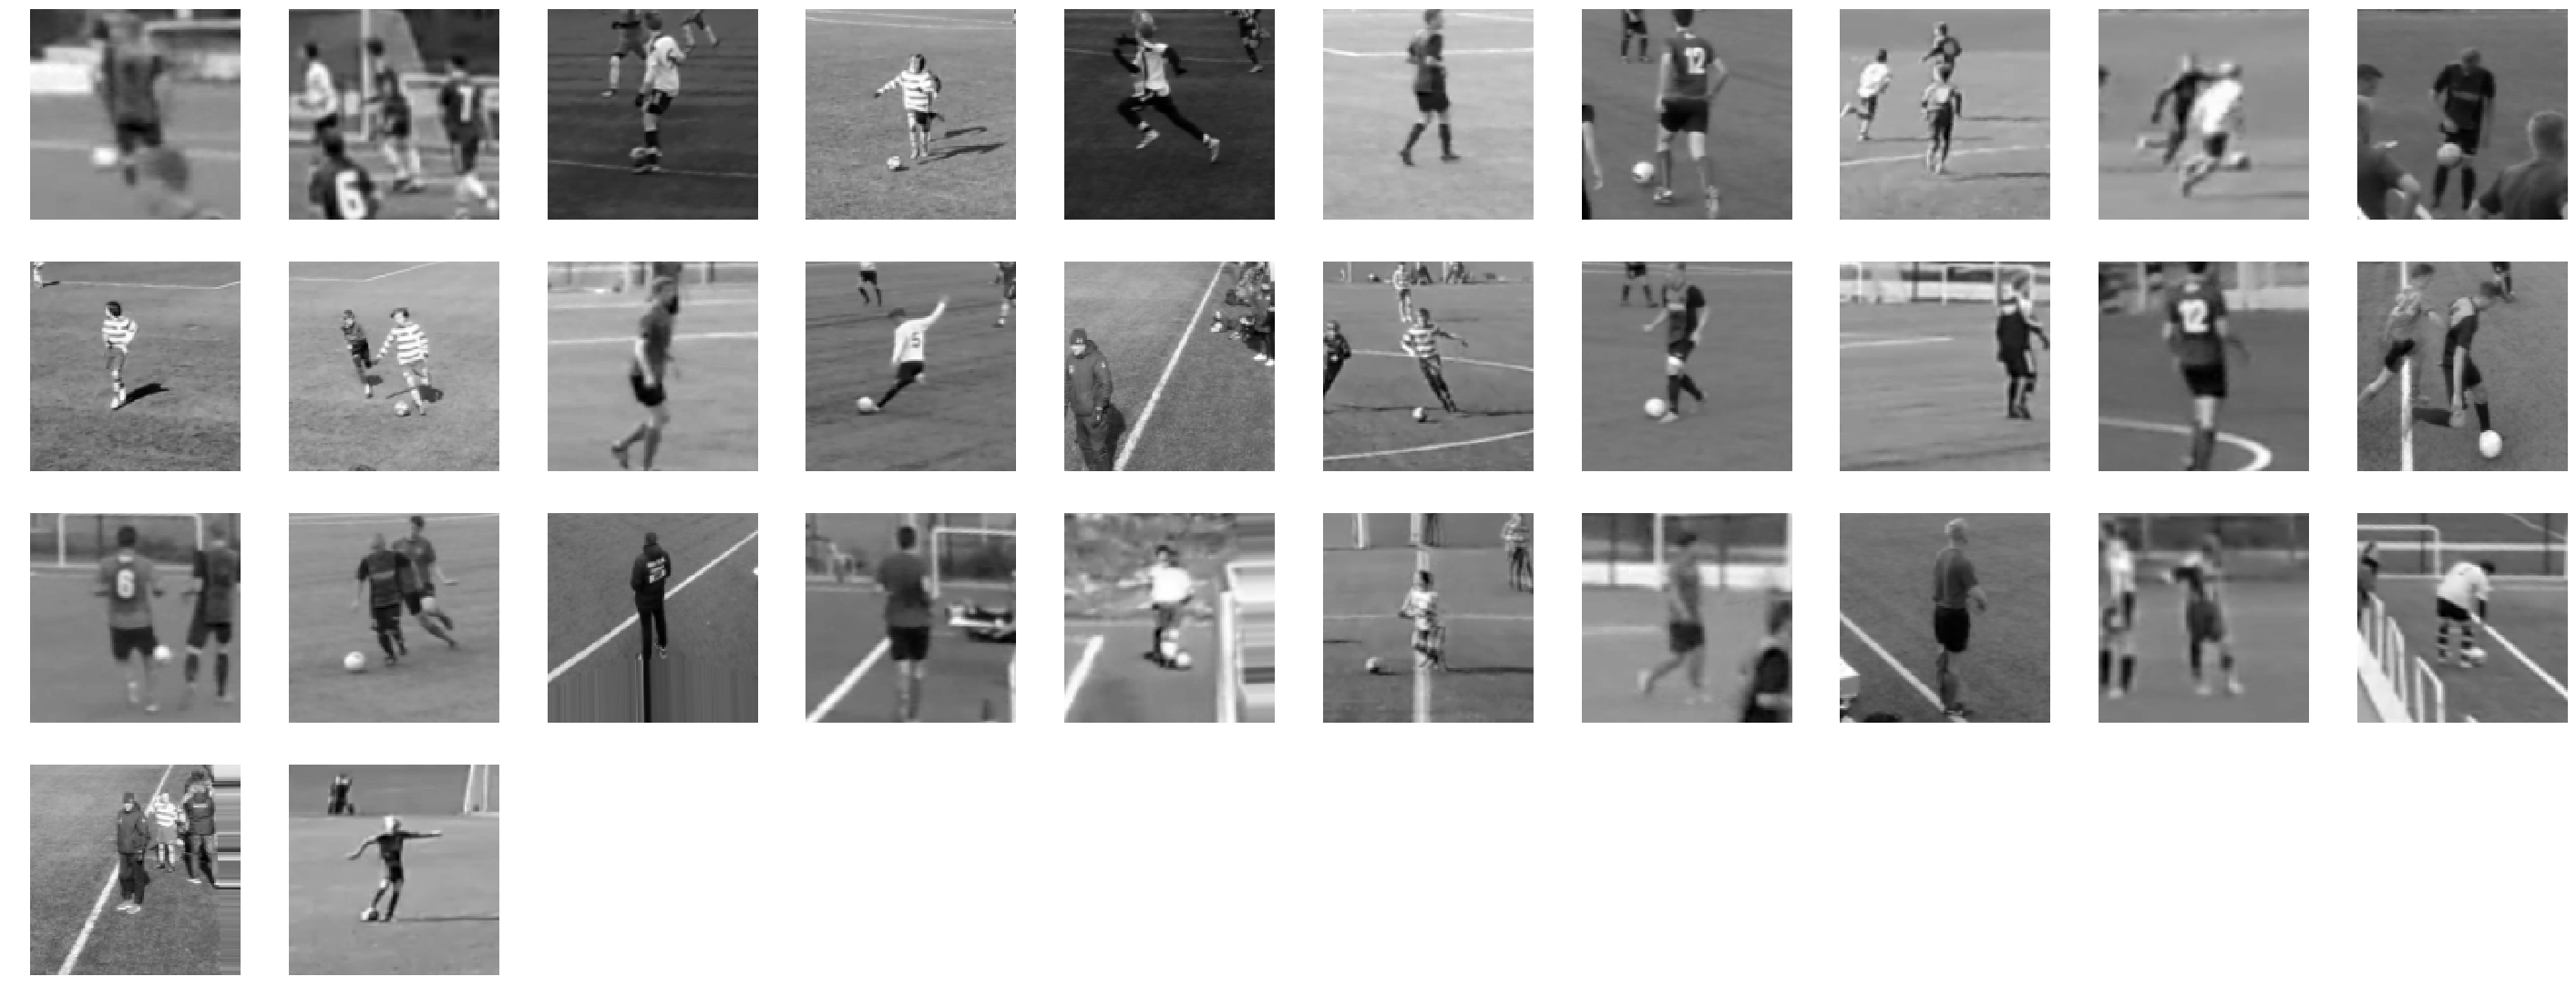

1.0		0.0		1.0		1.0		0.0		0.0		1.0		0.0		1.0		1.0		0.0		1.0		0.0		1.0		0.0		1.0		1.0		0.0		0.0		1.0		1.0		1.0		0.0		0.0		0.0		1.0		0.0		0.0		0.0		1.0		0.0		1.0		

In [7]:
# Display training images
print("Training images:")

fig = plt.figure(figsize=(100, 100))
for idx in range(len(training_image_appended)):
    plt.subplot(10, 10, idx + 1)
    image = np.squeeze(training_image_appended[idx])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

for idx in range(len(training_image_appended)):
    print(str(training_anno[idx,1])+"\t\t",end='')
    
print("\n")
          


# Display validation images
print("Validation images:")
fig = plt.figure(figsize=(50, 50))
for idx in range(len(validation_image_appended)):
    plt.subplot(10, 10, idx + 1)
    image = np.squeeze(validation_image_appended[idx])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

for idx in range(len(training_image_appended)):
    print(str(validation_anno[idx,1])+"\t\t",end='')

# Define Model

In [19]:
# resetting the graph ...
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_image_pl = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], name="x_image_pl")
t_pl = tf.placeholder(tf.float32, [None, NUM_OF_CLASSES], name="targets_pl")
preds_pl = tf.placeholder(tf.float32, [None, NUM_OF_CLASSES], name="pred_pl")
is_training_pl = tf.placeholder(tf.bool, name="is_training_pl")


with tf.name_scope('CNN_model'):
    l_conv1 = conv2d(x_image_pl, num_outputs=96, kernel_size=[11, 11], stride=4, normalizer_fn=batch_norm, scope='l_conv1')
    l_pool1 = max_pool2d(l_conv1, kernel_size=[2, 2], stride=2, scope='l_pool1')
    l_conv2 = conv2d(l_pool1, num_outputs=256, kernel_size=[5, 5],stride=1, normalizer_fn=batch_norm, scope='l_conv2')
    l_pool2 = max_pool2d(l_conv2, kernel_size=[2, 2], stride = 2, scope='l_pool2')
    l_conv3 = conv2d(l_pool2, num_outputs=512, kernel_size=[3, 3],stride=1, normalizer_fn=batch_norm, scope='l_conv3')
    l_conv4 = conv2d(l_conv3, num_outputs=1024, kernel_size=[3, 3],stride=1, normalizer_fn=batch_norm, scope='l_conv4')
    l_conv5 = conv2d(l_conv4, num_outputs=1024, kernel_size=[3, 3],stride=1, normalizer_fn=batch_norm, scope='l_conv5')
    l_pool5 = max_pool2d(l_conv5, kernel_size=[2, 2], stride = 2, scope='l_pool5')
    l_flatten = flatten(l_conv2, scope="l_flatten")###############################
   
    l_2 = fully_connected(l_flatten, num_outputs=16, activation_fn=relu, normalizer_fn=batch_norm, scope="l2")
    l_dropout_1 = dropout(l_2, is_training=is_training_pl, scope="l2_dropout")
    y = fully_connected(l_flatten, NUM_OF_CLASSES, activation_fn=softmax, scope="y")


In [20]:
# Print weights function

def get_weights(layer_name):
    with tf.variable_scope(layer_name,reuse = True):
        return sess.run(tf.get_variable("weights"))
    
def get_biases(layer_name):
    with tf.variable_scope(layer_name,reuse = True):
        try:
            biases = sess.run(tf.get_variable("biases"))
            return biases
        except ValueError:
            print("Bias doesn't exist")
            return
    


### Test forward pass

In [21]:
#Test the forward pass
_img_shape = tuple([8]+list(IMAGE_SHAPE))
_x_image = np.random.normal(0, 1, _img_shape).astype('float32') #dummy data

# test the forward pass
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    feed_dict = {x_image_pl: _x_image, is_training_pl: False}
    outputs = sess.run(fetches=[y], feed_dict=feed_dict)
    
print("y", outputs[0].shape)
a = 2
print("y = ")
print(outputs)

y (8, 2)
y = 
[array([[ 0.45841047,  0.54158956],
       [ 0.60634279,  0.39365724],
       [ 0.71034312,  0.28965685],
       [ 0.89774919,  0.10225076],
       [ 0.38974825,  0.61025172],
       [ 0.09105855,  0.90894145],
       [ 0.44940516,  0.55059487],
       [ 0.41092163,  0.58907837]], dtype=float32)]


# Build the cost function

In [22]:
def loss_and_acc(preds):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(t_pl * tf.log(preds+1e-10), reduction_indices=[1])
    # averaging over samples
    loss = tf.reduce_mean(cross_entropy)
    # if you want regularization
    reg_scale = 0.0001#0.0001
    regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    reg_term = sum([regularize(param) for param in params])
    loss += reg_term
    # calculate accuracy
    argmax_y = tf.to_int32(tf.argmax(preds, axis=1))
    argmax_t = tf.to_int32(tf.argmax(t_pl, axis=1))
    correct = tf.to_float(tf.equal(argmax_y, argmax_t))
    accuracy = tf.reduce_mean(correct)
    return loss, accuracy, argmax_y


In [23]:
loss_test, accuracy_test, prediction = loss_and_acc(preds_pl) 

t = np.array([[1, 0]])
preds = np.array([[0, 1]])

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    feed_dict = {t_pl: t, preds_pl: preds}
    fetches = [loss_test, accuracy_test] 
    outputs = sess.run(fetches=fetches, feed_dict=feed_dict)
    
    
print(outputs)

[23.137114, 0.0]


### Test cost function

In [24]:
### loss, accuracy and prediction
loss, accuracy, prediction = loss_and_acc(y) 

# test the forward pass
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    feed_dict = {x_image_pl: training_img, is_training_pl: False,t_pl: training_anno}
    #fetches = [y, loss, accuracy, prediction]
    fetches = [y, loss, accuracy]
    outputs = sess.run(fetches=fetches, feed_dict=feed_dict)

print("y")
print(outputs[0])

print("loss")
print(outputs[1])

print("accuracy")
print(outputs[2])

#print("prediction")
#print(outputs[3])

print("Targets")
print(training_anno)

y
[[ 0.71191448  0.28808549]
 [ 0.60049993  0.39950007]
 [ 0.7424643   0.2575357 ]
 [ 0.32823604  0.67176396]
 [ 0.3380706   0.66192937]
 [ 0.28278068  0.71721935]
 [ 0.70545226  0.29454777]
 [ 0.63490397  0.365096  ]
 [ 0.52402341  0.47597653]
 [ 0.33280596  0.66719407]
 [ 0.75151265  0.24848734]
 [ 0.726785    0.27321497]
 [ 0.56412375  0.43587628]
 [ 0.80767047  0.19232954]
 [ 0.83474195  0.16525805]
 [ 0.65587127  0.34412876]
 [ 0.70369196  0.29630804]
 [ 0.42399281  0.57600719]
 [ 0.50198984  0.4980101 ]
 [ 0.39911899  0.60088104]
 [ 0.80570167  0.19429836]
 [ 0.75380027  0.24619976]
 [ 0.49455523  0.50544482]
 [ 0.66793257  0.3320674 ]
 [ 0.79708606  0.2029139 ]
 [ 0.27002496  0.7299751 ]
 [ 0.29926407  0.70073593]
 [ 0.89974934  0.10025059]
 [ 0.78988314  0.21011688]
 [ 0.74914473  0.25085524]
 [ 0.67575496  0.32424504]
 [ 0.42901993  0.57098007]]
loss
0.825257
accuracy
0.625
Targets
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0

# Optimizer

In [25]:
### loss, accuracy and prediction
loss, accuracy, prediction = loss_and_acc(y) 

# defining our optimizer
LEARNING_RATE = 0.0001
clip_norm = 1
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

# applying the gradients
grads_and_vars = optimizer.compute_gradients(loss)
gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
clipped_gradients, global_norm = (tf.clip_by_global_norm(gradients, clip_norm))
clipped_grads_and_vars = zip(clipped_gradients, variables)

# make training op for applying the gradients
train_op = optimizer.apply_gradients(clipped_grads_and_vars)

# make tensorboard summeries
tf.summary.scalar('global_gradient_norm', global_norm)
tf.summary.scalar('Evaluation/loss', loss)
tf.summary.scalar('Evaluation/accuracy', accuracy)

<tf.Tensor 'Evaluation/accuracy:0' shape=() dtype=string>

# Training

In [26]:
#Training Loop
NUM_OF_BATCHES = 1000
LOG_FREQ = 10
VALID_EVERY = 10
SAVE_EVERY = 1000
DROPOUT = False

flag_use_trained_model = False
save_name = "His_Loss"
load_name = "His_Loss_20171207-123827-30"

In [ ]:
# setup and write summaries
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summaries_path = "tensorboard/%s" % (timestamp)
summaries = tf.summary.merge_all()


summarywriter_train = tf.summary.FileWriter(summaries_path + '/train', sess.graph)
summarywriter_valid = tf.summary.FileWriter(summaries_path + '/valid', sess.graph)

#with graph.as_default():
saver = tf.train.Saver(max_to_keep = 2)

train_loss_vec = []
train_acc_vec = []

try:
    filename_training_queue = tf.train.string_input_producer(
         [tfrecords_training_filepath], num_epochs=NUM_EPOCHS)
    filename_validation_queue = tf.train.string_input_producer(
        [tfrecords_validation_filepath], num_epochs=NUM_EPOCHS)

    # Even when reading in multiple threads, share the filename queue.
    training_image, training_annotation = read_and_decode(filename_training_queue, TRAINING_BATCH_SIZE)
    validation_image, validation_annotation = read_and_decode(filename_validation_queue, VALIDATION_BATCH_SIZE)

    # The op for initializing the variables.
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts,log_device_placement = True))  as sess:
        if flag_use_trained_model:
            #sess.run(tf.local_variables_initializer())
            sess.run(init_op)
            # Restore variables from disk.
            saver.restore(sess, os.path.join(script_path, "tmp" + os.sep + load_name))
            #print(get_biases('y'))
        else:
            sess.run(init_op)
    
        # Controlling of threads
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        print("\trun time \ttrain_loss \ttrain_acc \tvalid_loss \tvalid_acc")
        start_time = time.time()
        # Load batches of data
        for i in range(NUM_OF_BATCHES+1):
            
            if i % 1 == 0:
                print("i: %d"% i)
            
            # Get training batch
            training_img, training_anno = sess.run([training_image, training_annotation])
            training_anno = np.squeeze(training_anno, axis=(1,2,3))
            training_anno= onehot(training_anno,NUM_OF_CLASSES)
            
            
            # Set fetches and feed_dict
            fetches_train = [train_op, loss, accuracy, summaries]
            feed_dict_train = {
                x_image_pl: training_img,
                t_pl: training_anno,
                is_training_pl: DROPOUT,
            }
            
            res_train = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
            
            if i % LOG_FREQ == 0:
                summarywriter_train.add_summary(res_train[3], i)
            train_loss_vec.append(res_train[1])
            train_acc_vec.append(res_train[2])
            
            
            # validate
            if i % VALID_EVERY == 0 and i != 0:
                
                cur_acc = 0
                cur_loss = 0
                
                for j in range(VALIDATION_BATCH_NUM):
                    # Load validation data
                    validation_img, validation_anno = sess.run([validation_image, validation_annotation])
                    validation_anno = np.squeeze(validation_anno, axis=(1,2,3))
                    validation_anno= onehot(validation_anno,NUM_OF_CLASSES)
                
                
                    # fetches and feed_dict for validation
                    fetches_valid = [loss, accuracy, summaries]
                    feed_dict_valid = {
                        x_image_pl: validation_img,
                        t_pl: validation_anno,
                        is_training_pl: False,
                    }
                    # run validation
                    res_valid = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
                    cur_acc += res_valid[1]
                    cur_loss += res_valid[0]
                    summarywriter_valid.add_summary(res_valid[2], i) # save the vali summary
                    
                
                # tensorboard and costs
                valid_loss = cur_loss/VALIDATION_BATCH_NUM   # Validation loss
                valid_acc  = cur_acc/VALIDATION_BATCH_NUM * 100   # Validation accuracy 
    
                train_loss = sum(train_loss_vec) / float(len(train_loss_vec))
                train_acc = sum(train_acc_vec) / float(len(train_acc_vec)) * 100
                
                end_time = time.time()
                print("%d:\t %.2f\t\t  %.2f\t\t  %.1f\t\t  %.2f\t\t  %.1f" % (i, end_time-start_time, train_loss, train_acc, valid_loss, valid_acc))
                
                train_loss_vec = []
                train_acc_vec = []
                
                #print(get_biases('y'))
                                
                     
            if i % SAVE_EVERY == 0 and i != 0:
                timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                save_path = saver.save(sess, os.path.join(script_path, "tmp" + os.sep + save_name + "_" + timestamp), global_step=i)
                load_name = save_name + "_" + timestamp + "-" + str(i)
                
        # Stop threads
        coord.request_stop()
        coord.join(threads)
        print("DONE")
except KeyboardInterrupt:
    print(get_biases('y'))
    coord.request_stop()
    coord.join(threads)
    print("INTERRUPTED")
    pass

	run time 	train_loss 	train_acc 	valid_loss 	valid_acc
i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
10:	 21.80		  1.00		  61.1		  1.16		  62.5
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
20:	 36.63		  0.90		  66.6		  1.11		  59.4
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
30:	 51.37		  0.78		  66.9		  0.88		  65.6
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
40:	 66.46		  0.80		  68.1		  0.70		  75.0
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
50:	 81.71		  0.72		  70.6		  0.83		  65.6
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
60:	 97.18		  0.69		  72.5		  0.66		  65.6
i: 61
i: 62
i: 63
i: 64
i: 65
i: 66
i: 67
i: 68
i: 69
i: 70
70:	 112.45		  0.64		  74.4		  0.74		  68.8
i: 71
i: 72
i: 73
i: 74
i: 75
i: 76
i: 77
i: 78
i: 79
i: 80
80:	 127.79		  0.78		  67.2		  0.74		  68.8
i: 81
i: 82
i: 83
i: 84
i: 85
i: 86
i: 87
i: 88
i: 89
i: 90
90:	 144.09		  0.75		  70.0		  0.72		  65.6
i: 91
i: 92
i: 93


### Validation benchmark

In [ ]:
print(load_name)
print(type(load_name))

In [ ]:
filename_validation_queue_benchmark = tf.train.string_input_producer([tfrecords_validation_filepath], num_epochs=1)
validation_image, validation_annotation = read_and_decode(filename_validation_queue_benchmark, VALIDATION_BATCH_SIZE)
#load_name = "His_Loss_20171207-143841-5000"

# TF save object
saver = tf.train.Saver()
# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts,log_device_placement = True))  as sess:
    sess.run(init_op)
    # Restore variables from disk.
    saver.restore(sess, os.path.join(script_path, "tmp" + os.sep + load_name))
            
    # Controlling of threads
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    
    # Some validation stuff
    cur_acc = 0
    cur_loss = 0
    tot_num = 0
    
    # Load validation data
    try:
        while(True):
            validation_img, validation_anno = sess.run([validation_image, validation_annotation])
            validation_anno = np.squeeze(validation_anno, axis=(1,2,3))
            validation_anno= onehot(validation_anno,NUM_OF_CLASSES)
            
            
            # fetches and feed_dict for validation
            fetches_valid = [loss, accuracy, summaries]
            feed_dict_valid = {
                x_image_pl: validation_img,
                t_pl: validation_anno,
                is_training_pl: False,
            }
            # run validation
            res_valid = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
            
            cur_loss += res_valid[0]*VALIDATION_BATCH_SIZE   # Validation loss
            cur_acc  += res_valid[1]*VALIDATION_BATCH_SIZE   # Validation accuracy 
            tot_num += VALIDATION_BATCH_SIZE
    except tf.errors.OutOfRangeError:
        # Stop threads
        coord.request_stop()
        coord.join(threads)
    finally:
        # tensorboard and costs
        valid_loss = cur_loss / float(tot_num)
        valid_acc = (cur_acc / float(tot_num)) * 100
        
        print("Validation size: %d,\tLoss: %.2f,\tAccuracy: %.1f" % (tot_num, valid_loss, valid_acc))